This notebook will develop a machine learning model to perform fraudulent transaction detection for transactions performed on a mobile payment system. The transaction data is generated by a simulator that generates 31 days of transactions that are statistically similar to real transactions performed on a real mobile payment system for the same period of time. If you would like to know more about the data set you can go [here](https://www.kaggle.com/ntnu-testimon/paysim1).

# Module Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import re
import time
import pickle
import os
import datetime
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, classification_report, confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve

from xgboost import XGBClassifier
from xgboost import plot_importance, to_graphviz

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

import pymysql.cursors
import sys

#to speed up pandas operands
from pandarallel import pandarallel

#GPU

import cupy as cnp
import cudf
import numpy as np
import pandas as pd
import datetime as dt
import gc
from sklearn.preprocessing import LabelEncoder
from cuml import train_test_split as gputrain_test_split
from cuml import LinearRegression as gpuLinearRegression
from cuml import KMeans as gpuKmeans
from cuml import LogisticRegression as gpuLogisticRegression
from cuml.ensemble import RandomForestClassifier as gpuRandomForestClassifier
from cuml.experimental.preprocessing import scale

In [2]:
#These are top-level variables used to control the operation of the notebook

#random seed used to initialize machine learning models and data set maniuplation functions
RANDOM_STATE = 999

#used to determine what percent of the overall data set will be used for testing trained models
TEST_SIZE = 0.1

# When this is a 1, this notebook will access clean the data on the SQL server and download the data to this notebook
# please note this will require credentials and it takes time
#
# In lieu of that I can make available a pickle file of the post-cleaned SQL table in which case
# you can ask me for it and you won't need to set this variable to 1.
#
RUN_TABLE_CREATE_IMPORT = 0

#if this is a one it will read from data from the SQL server before performing EDA
#note you will need credentials to do this. Otherwise you will have to use a pickle file which I can make available
#upon request
READ_FROM_SQL_SERVER = 0

# Data Import Data Cleaning In SQL

The data is uploaded to a remote SQL server. The credentials to that server is accessesd by this notebook in a file held securely. If you would like access to this server please let me know and I'll send it to you. 

Here I am reading in the first few lines of the data set to get the names of the columns and the types of data within each column.

In [3]:
data_df = pd.read_csv("../Data/PS_20174392719_1491204439457_log.csv",nrows=5)
data_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
#COL_NAMES will be used to clean the database on the SQL server
COL_NAMES = data_df.columns
COL_NAMES = list(COL_NAMES)
COL_NAMES.remove("type")
COL_NAMES.append("transtype")
for i, a_col in enumerate(COL_NAMES):
    print(a_col)

step
amount
nameOrig
oldbalanceOrg
newbalanceOrig
nameDest
oldbalanceDest
newbalanceDest
isFraud
isFlaggedFraud
transtype


So this information will be used to create the SQL table.

Obtaining credentials to log into the SQL server. Note this was developed to work on a mac or a Linux machine.

In [5]:
#Establishing connection to mariaDB server
#Note, sever_details.txt is not provided you'll have to ask me for it
if sys.platform == 'linux':
    server_details_file_name = "/home/magreen/Dropbox/PERSONAL/Documents/Word/server_details.txt"
elif sys.platform == 'darwin':
    server_details_file_name = "/Users/magreen/Dropbox/PERSONAL/Documents/Word/server_details.txt"
else:
    print("WARNING: You are running on a system type I have not tested. Please contact me if you want help testing this.")

SERVER_DETAILS = open(server_details_file_name,"r")
line_of_text = SERVER_DETAILS.readline()

host_name, username, mypassword, db_name = line_of_text.split(',')

host_name = host_name.rstrip()
host_name = host_name.lstrip()
username = username.rstrip()
username = username.lstrip()
mypassword = mypassword.rstrip()
mypassword = mypassword.lstrip()
db_name = db_name.rstrip()
db_name = db_name.lstrip()

In [6]:
#This data frame is no longer needed so deleting it
del data_df

Creating a connection to the SQL server

In [7]:
connection = pymysql.connect(host=host_name, user=username, password=mypassword, db=db_name, cursorclass=pymysql.cursors.DictCursor)

So this code will create the table on the SQL server, upload a copy of the original [data set CSV file](https://www.kaggle.com/ntnu-testimon/paysim1), remove rows that may contain null data, and find and remove duplicate rows.

In [8]:
#get a cursor
mycursor = connection.cursor()

In [9]:
#Create table import entire CSV
if RUN_TABLE_CREATE_IMPORT != 0:
    drop_table_query = "drop table if exists paysim_data2;"

    mycursor.execute(drop_table_query)
    mycursor.execute("commit;")

    create_table_query = """


create table paysim_data2 (
    step INT,
    transtype VARCHAR(255),
    amount REAL,
    nameOrig VARCHAR(255),
    oldbalanceOrg REAL,
    newbalanceOrig REAL,
    nameDest VARCHAR(255),
    oldbalanceDest REAL,
    newbalanceDest REAL,
    isFraud INT,
    isFlaggedFraud INT
    );


    """
    mycursor.execute(create_table_query)
    mycursor.execute("commit;")

    import_query = """


load data infile '/var/lib/mysql-files/data/PS_20174392719_1491204439457_log.csv'
into table paysim_data2 fields terminated by ','  lines terminated by '\n'
ignore 1 rows;

    """

    mycursor.execute(import_query)
    mycursor.execute("commit;")
    
    #and a row ID to the table
    alter_table_query = """
    alter table paysim_data2 add column id int auto_increment primary key first;
    """
    mycursor.execute(alter_table_query)
    mycursor.execute("commit;")
    print("table creation and import done")
else:
    print("Skipping MySQL table creation and CSV import")

Skipping MySQL table creation and CSV import


In this section I remove rows that contain null entries or duplicate entries from the SQL table.

In [10]:
########################################################################
#
# Search each column in the MySQL table for null. If null remove the row
#
########################################################################
if RUN_TABLE_CREATE_IMPORT != 0:

    for column_name in COL_NAMES:
        temp_query = """
    
        select * from paysim_data2 where {} is null;
    
        """.format(column_name)
    
        mycursor.execute("begin;")
        query_result = mycursor.execute(temp_query)
        print("For column = {} here are the null rows:\n".format(column_name))
        print(query_result)
        print("\n")
    
        if query_result != 0:
            row_contents = mycursor.fetchall()
            print("This row contains NULL information:\n")
        
            for bad_row in row_contents:
                print(row_contents)
            
            temp_efface_row_query = """
            delete from paysim_data2 where {} is null;
            """.format(column_name)
        
            query_result = mycursor.execute(temp_efface_row_query)
        
            #print("result = {}".format(query_result))
            mycursor.execute("commit;")
            #print("result = {}".format(query_result))
            if query_result:
                print("\nsuccessfully removed row\n")
            else:
                print("error: failed to remove row!")
        
    

        
    print("\ncheck done.\n")
else:
    print("\nskipping null search and clean\n")



skipping null search and clean



In [11]:
########################################################################
#
# Search for duplicate rows. Remove the second-most row for every pair of duplicate rows
#
########################################################################

search_for_duplicates_query = """
select
     step, count(step),
     transtype, count(transtype),
     amount, count(amount),
     nameOrig, count(nameOrig),
     oldbalanceOrg, count(oldbalanceOrg),
     newbalanceOrig, count(newbalanceOrig),
     nameDest, count(nameDest),
     oldbalanceDest, count(oldbalanceDest),
     newbalanceDest, count(newbalanceDest),
     isFraud, count(isFraud),
     isFlaggedFraud, count(isFlaggedFraud)
     from paysim_data2
     group by step,transtype,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
     having
     count(step) > 1 and
     count(transtype) > 1 and
     count(amount) > 1 and
     count(nameOrig) > 1 and
     count(oldbalanceOrg) > 1 and
     count(newbalanceOrig) > 1 and
     count(nameDest) > 1 and
     count(oldbalanceDest) > 1 and
     count(newbalanceDest) > 1 and
     count(isFraud) > 1 and
     count(isFlaggedFraud) > 1;



"""

remove_duplicates_query1 = """


SET SESSION old_alter_table=1;


"""

remove_duplicates_query2 = """

alter ignore table paysim_data2 add unique index u(amount,nameOrig,nameDest);


"""


remove_duplicates_query3 = """
SET SESSION old_alter_table=0;


"""
if RUN_TABLE_CREATE_IMPORT != 0:

    # removing duplicates takes too long will just search for duplicates
    # The dataset has 6M rows every duplicate remove I found 
    # does a n^2 operation which is too many for this DB
    # other methods (CTE) don't work
    mycursor.execute("begin;")
    mycursor.execute(search_for_duplicates_query)
    results = mycursor.fetchall()

    print("following are duplicate rows in the SQL DB:\n")
    for myresult in results:
        print(myresult)
    print("\ndone searching for duplicates\n")

    print("removing duplicates\n")
    mycursor.execute("begin;")
    mycursor.execute(remove_duplicates_query1)
    mycursor.execute("commit;")
    mycursor.execute(remove_duplicates_query2)
    mycursor.execute("commit;")
    mycursor.execute(remove_duplicates_query3)
    mycursor.execute("commit;")
    print("\ndone removing duplicates\n")
else:
    print("\nskipping redundant row search and remove\n")



skipping redundant row search and remove



# Exploratory Data Analysis
Things I want to do in this section:

* Determine if this data set has a class imbalance
* Discuss meaning of the data set to hopefully aid understanding of the rest of this notebook
* Find or create a feature that would aid a machine learning model is automatically distignuishing data points that belong in label A from those that belong in label B

## Final import of data before EDA

In [12]:
if READ_FROM_SQL_SERVER:
    get_paysim_data2_table_query = "select * from paysim_data2;"
    paysim_data_df = pd.read_sql(get_paysim_data2_table_query,connection)
    DF_PICKLE_FILE = open("paysim_data_df.pkl","wb")
    pickle.dump(paysim_data_df,DF_PICKLE_FILE)
    DF_PICKLE_FILE.close()
else:
    DF_PICKLE_FILE = open("paysim_data_df.pkl","rb")
    paysim_data_df = pickle.load(DF_PICKLE_FILE)

There is definitely a class impbalance:

In [13]:
paysim_data_df["isFraud"].value_counts()

0    6354408
1       8213
Name: isFraud, dtype: int64

In [14]:
paysim_data_df.head()

,id,step,transtype,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,2,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,3,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,4,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,5,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Explanation and Analysis

Based on the [paper](http://bth.diva-portal.org/smash/record.jsf?pid=diva2%3A955852&dswid=-5720) of the computer scientist that developed the data set this is how you can interpret the various columns of the data frame above:

* `step`: A unit of time in the simulation. Each time step represents 1 hour.
* `transtype`(note renamed from `type` in the original CSV): A categorical feature that can take on the values `CASH-IN`, `CASH-OUT`, `DEBIT`, `PAYMENT`, or `TRANSFER`
* `amount`: Floating point number representing the amount of the transaction.
* `nameOrig`: An anonymized string that identifies the account from which the transaction originated
* `oldbalance`: Initial amount in the `nameOrig` account before transaction has completed
* `newbalanceOrig`: Final amount in `nameOrig` account after transaction has completed
* `nameDest`: An anonymized string that identifies the account to which the transaction is destined
* `oldbalanceDest`: Initial amount in the nameDest account before transaction has completed
* `newblanaceDest`: Final amount in nameDest account after transaction hasa completed
* `isFraud`: If this is a 1, it's a fraudulent transaction. If it is a 0 it is not a fradulent transaction
* `isFlaggedFraud`: The indication of whether or not the simulated payment system automatically marked the transaction is fraud. You can consider it an indication of well the current payment system is finding fraudulent transfers

`id` is the primary key row ID from the database. It can be ignored.




`CASH-IN`:
This is an operation where `nameOrig` is putting money into his/her/their account. So in these transfers `newbalanceOrig` = `amount`+`oldbalanceOrg`. You can ignore what is happening with `*Dest` columns. It appears that `CASH-IN` does not apply to these columns.

In [15]:
#Seems there are a lot of transactions where there is an off by 0.01 in the results
mask1 = (paysim_data_df["transtype"] == "CASH_IN") & ( (paysim_data_df["amount"]+paysim_data_df["oldbalanceOrg"]) == paysim_data_df["newbalanceOrig"])
mask2 = (paysim_data_df["transtype"] == "CASH_IN") & ( (paysim_data_df["amount"]+paysim_data_df["oldbalanceOrg"]- 0.01) == paysim_data_df["newbalanceOrig"] )
mask3 = (paysim_data_df["transtype"] == "CASH_IN") & ( (paysim_data_df["amount"]+paysim_data_df["oldbalanceOrg"]+ 0.01) == paysim_data_df["newbalanceOrig"] )

paysim_data_df[mask1 | mask2 |mask3].head()

,id,step,transtype,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
389,390,1,CASH_IN,143236.26,C1862994526,0.00,143236.26,C1688019098,608932.17,97263.78,0,0
390,391,1,CASH_IN,228451.89,C1614133563,143236.26,371688.15,C2083562754,719678.38,1186556.81,0,0
391,392,1,CASH_IN,35902.49,C839771540,371688.15,407590.65,C2001112025,49003.30,0.00,0,0
392,393,1,CASH_IN,232953.64,C1037163664,407590.65,640544.28,C33524623,1172672.27,1517262.16,0,0
393,394,1,CASH_IN,65912.95,C180316302,640544.28,706457.23,C1330106945,104198.26,24044.18,0,0


`CASH-OUT` is the opposite of `CASH-IN`. But please take note that this does not always hold true

In [16]:
#here are some transactions that are cash-in but don't satisfy the requirements above
mask1 = paysim_data_df["transtype"] == "CASH_OUT"
mask2 = ( (paysim_data_df["oldbalanceOrg"] - paysim_data_df["amount"] ) == paysim_data_df["newbalanceOrig"])
mask3 = ( (paysim_data_df["oldbalanceOrg"] - paysim_data_df["amount"]- 0.01) == paysim_data_df["newbalanceOrig"] )
mask4 = ( (paysim_data_df["oldbalanceOrg"] - paysim_data_df["amount"] + 0.01) == paysim_data_df["newbalanceOrig"] )

#it's a cash-in but is not +/- 0.01 totaling up correctly
#mask = mask1 & ~(mask2 | mask3 | mask4)

mask = mask1 & (mask2 | mask3 | mask4)
#mask = mask1 & (~(mask2) & ~(mask3) &  ~(mask4))

paysim_data_df[mask].head()

,id,step,transtype,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3,4,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
71,72,1,CASH_OUT,136872.92,C1533123860,162075.98,25203.05,C766572210,217806.00,0.00,0,0
252,253,1,CASH_OUT,2806.00,C2101527076,2806.00,0.00,C1007251739,26202.00,0.00,1,0
665,666,1,CASH_OUT,227768.63,C1445424568,1011466.31,783697.68,C1023714065,530123.48,1412484.09,0,0
666,667,1,CASH_OUT,172986.70,C1374217958,783697.68,610710.98,C33524623,686295.71,1517262.16,0,0


`DEBIT` is the process of taking money out of a mobile money service account and placing it in an accout external to the mobile money system.

In [17]:
#here are some transactions that are cash-in but don't satisfy the requirements above
mask1 = paysim_data_df["transtype"] == "DEBIT"
mask2 = ( (paysim_data_df["oldbalanceOrg"] - paysim_data_df["amount"] ) == paysim_data_df["newbalanceOrig"])
mask3 = ( (paysim_data_df["oldbalanceOrg"] - paysim_data_df["amount"]- 0.01) == paysim_data_df["newbalanceOrig"] )
mask4 = ( (paysim_data_df["oldbalanceOrg"] - paysim_data_df["amount"] + 0.01) == paysim_data_df["newbalanceOrig"] )

#it's a cash-in but is not +/- 0.01 totaling up correctly
#mask = mask1 & ~(mask2 | mask3 | mask4)

mask = mask1 & (mask2 | mask3 | mask4)
#mask = mask1 & (~(mask2) & ~(mask3) &  ~(mask4))

paysim_data_df[mask].head()

,id,step,transtype,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
41,42,1,DEBIT,5758.59,C1466917878,32604.0,26845.41,C1297685781,209699.0,16997.22,0,0
59,60,1,DEBIT,5529.13,C867288517,8547.0,3017.87,C242131142,10206.0,0.00,0,0
61,62,1,DEBIT,4510.22,C280615803,10256.0,5745.78,C1254526270,10697.0,0.00,0,0
62,63,1,DEBIT,8727.74,C166694583,882770.0,874042.26,C1129670968,12636.0,0.00,0,0
121,122,1,DEBIT,864.68,C1368862151,69836.0,68971.32,C20671747,12040.0,43691.09,0,0


`PAYMENT` is a transaction that invovles a customer purchasing goods and services from a merchant that operates on the same mobile payment system.

In [18]:
#here are some transactions that are cash-in but don't satisfy the requirements above
mask1 = paysim_data_df["transtype"] == "PAYMENT"
mask2 = ( (paysim_data_df["oldbalanceOrg"] - paysim_data_df["amount"] ) == paysim_data_df["newbalanceOrig"])
mask3 = ( (paysim_data_df["oldbalanceOrg"] - paysim_data_df["amount"]- 0.01) == paysim_data_df["newbalanceOrig"] )
mask4 = ( (paysim_data_df["oldbalanceOrg"] - paysim_data_df["amount"] + 0.01) == paysim_data_df["newbalanceOrig"] )

#it's a cash-in but is not +/- 0.01 totaling up correctly
#mask = mask1 & ~(mask2 | mask3 | mask4)

mask = mask1 & (mask2 | mask3 | mask4)
#mask = mask1 & (~(mask2) & ~(mask3) &  ~(mask4))

paysim_data_df[mask].head()

,id,step,transtype,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,2,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
4,5,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
5,6,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0
6,7,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0


`TRANSFERS` are transactions that involve a customer sending money directly to another customer's accout that operates on the same mobile payment system.

What is noticed is that there is only one account that accounts for this correctly

In [19]:
#here are some transactions that are cash-in but don't satisfy the requirements above
mask1 = paysim_data_df["transtype"] == "TRANSFER"
mask2 = ( (paysim_data_df["oldbalanceOrg"] - paysim_data_df["amount"] ) == paysim_data_df["newbalanceOrig"])
mask3 = ( (paysim_data_df["oldbalanceOrg"] - paysim_data_df["amount"]- 0.01) == paysim_data_df["newbalanceOrig"] )
mask4 = ( (paysim_data_df["oldbalanceOrg"] - paysim_data_df["amount"] + 0.01) == paysim_data_df["newbalanceOrig"] )

mask5 = ( (paysim_data_df["oldbalanceDest"] + paysim_data_df["amount"] ) == paysim_data_df["newbalanceDest"])
mask6 = ( (paysim_data_df["oldbalanceDest"] + paysim_data_df["amount"]- 0.01) == paysim_data_df["newbalanceDest"] )
mask7 = ( (paysim_data_df["oldbalanceDest"] - paysim_data_df["amount"] + 0.01) == paysim_data_df["newbalanceDest"] )

#it's a cash-in but is not +/- 0.01 totaling up correctly
#mask = mask1 & ~(mask2 | mask3 | mask4)

mask = mask1 & (mask2 | mask3 | mask4) & (mask5 | mask6 | mask7)
#mask = mask1 & (~(mask2) & ~(mask3) &  ~(mask4))

paysim_data_df[mask].head(10)

,id,step,transtype,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2125,2126,1,TRANSFER,22190.99,C2017380745,52231.01,30040.03,C1170794006,0.00,22190.99,0,0
2378,2379,1,TRANSFER,15326.30,C353296011,105867.00,90540.70,C1182908789,0.00,15326.30,0,0
3844,3845,3,TRANSFER,11500.28,C1679352734,21220.00,9719.72,C691404076,8671.64,20171.92,0,0
4200,4201,3,TRANSFER,16208.50,C1178160997,24318.00,8109.50,C99219259,0.00,16208.50,0,0
4428,4429,4,TRANSFER,11218.84,C621197441,49697.00,38478.16,C1292838001,29479.34,40698.18,0,0
4569,4570,4,TRANSFER,25424.16,C1179830093,52407.00,26982.84,C1651379334,49947.00,75371.16,0,0
4640,4641,4,TRANSFER,14237.75,C54440148,30258.00,16020.25,C116289363,0.00,14237.75,0,0
5043,5044,5,TRANSFER,29352.63,C1785536499,50904.00,21551.37,C1725097945,19248.70,48601.33,0,0
5053,5054,5,TRANSFER,1221.69,C814647201,52332.00,51110.31,C1211297851,34410.65,35632.33,0,0
6202,6203,6,TRANSFER,3849.48,C898959467,99474.00,95624.52,C1346667529,64017.81,67867.28,0,0


What is shown below is the following:

* there 0 transactions that are both marked as fraud and that mathematically add up

Because of this I cannot filter out these transactions as there is something going on with the simulation: either there is a bug or there is some assumption about how to interpret transactions in the data set that is not documented.

There are a lot of other people who have examined the data set and found such descrepancies: [1](https://www.kaggle.com/ntnu-testimon/paysim1/discussion/35004), [2](https://www.kaggle.com/lightcc/money-doesn-t-add-up/), and [3](https://www.kaggle.com/ntnu-testimon/paysim1/discussion/32786)


In [20]:
is_fraud_but_adds_up = (paysim_data_df["isFraud"] == 1) & mask
paysim_data_df[is_fraud_but_adds_up].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 0 entries
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              0 non-null      int64  
 1   step            0 non-null      int64  
 2   transtype       0 non-null      object 
 3   amount          0 non-null      float64
 4   nameOrig        0 non-null      object 
 5   oldbalanceOrg   0 non-null      float64
 6   newbalanceOrig  0 non-null      float64
 7   nameDest        0 non-null      object 
 8   oldbalanceDest  0 non-null      float64
 9   newbalanceDest  0 non-null      float64
 10  isFraud         0 non-null      int64  
 11  isFlaggedFraud  0 non-null      int64  
dtypes: float64(5), int64(4), object(3)
memory usage: 0.0+ bytes


**Action to be taken**:So I will not filter out any transactions that don't add up per the transaction definition as there may be some underlying assumptions about how to interpret these transactions that I am not aware of.


In [21]:
fraud_counts_dict = {}
notfraud_counts_dict = {}
transtypes = paysim_data_df["transtype"].unique()
#transtypes = transtypes.to_pandas()

for transtype in list(transtypes):
    numb_of_fraud_nofraud = paysim_data_df[ paysim_data_df["transtype"] == transtype ]["isFraud"].value_counts()
    #print(type(numb_of_fraud_nofraud))
    
    if numb_of_fraud_nofraud.get(1):
        fraud_counts_dict[transtype] = numb_of_fraud_nofraud[1]
    else:
        fraud_counts_dict[transtype] = 0
        
    if numb_of_fraud_nofraud.get(0):
        notfraud_counts_dict[transtype] = numb_of_fraud_nofraud[0]
    else:
        notfraud_counts_dict[transtype] = 0

In [22]:
col_names = ["type","fraud","notfraud"]
rows = [
    list(notfraud_counts_dict.keys()),
    list(fraud_counts_dict.values()),
    list(notfraud_counts_dict.values())
]

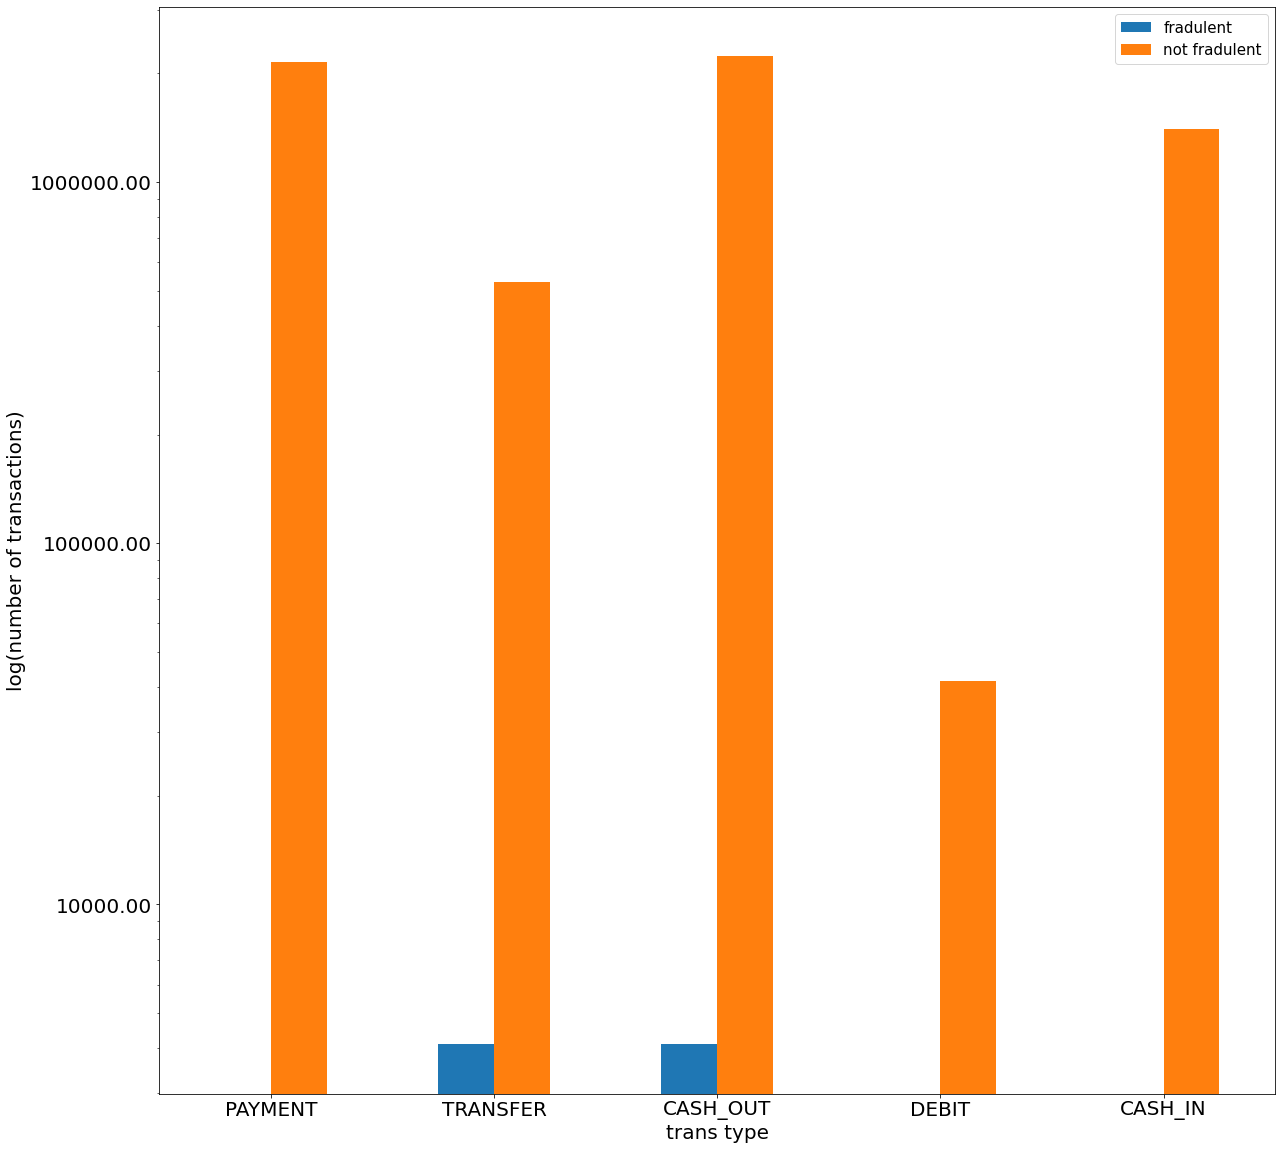

In [23]:
thefinal_dict = dict(zip(col_names,rows))

myplot_df = pd.DataFrame(thefinal_dict)
myplot_df = myplot_df.set_index("type")
myplot_df.plot(kind='bar',figsize=(20,20),logy=True,fontsize=20)
#plt.figure(figsize=(20,20))
plt.ylabel("log(number of transactions)",fontsize=20)
plt.xlabel("trans type",fontsize=20)
plt.legend(["fradulent","not fradulent"],fontsize=15)
plt.gca().yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.gca().xaxis.set_tick_params(rotation=0)
plt.savefig('fraud_not_fraud_per_xfer.png')

What I get from this graph:
* There are several orders of magnitude more `isFraud==0` transactions than `isFraud==1` transactions
* All `isFraud==1` transactions are either `TRANSFER` or `CASH_OUT` transaction types

What can be said about the amounts associated with fraudlent and non-fraudulent transactions?

In [24]:
paysim_data_df[ paysim_data_df["isFraud"] == 1 ]["amount"].describe()

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

In [25]:
paysim_data_df[ paysim_data_df["isFraud"] == 0 ]["amount"].describe()

count    6.354408e+06
mean     1.781970e+05
std      5.962369e+05
min      1.000000e-02
25%      1.336839e+04
50%      7.468468e+04
75%      2.083647e+05
max      9.244552e+07
Name: amount, dtype: float64


From the paper here are the modes of fraud reflected in the data set:

* transfers out money: the fraudster obtains access to another person's account. Then said fraudster cashes out this account or transfers the money to one or more destination accounts that the fraudster owns.
* cashes out the money: the fraudster obtains access to another person's account. Then said fraudster converts the account balance to cash using a merchant as a conduit for the transaction. Either the fraudster can use the merchant as an ATM or makes a purchase and uses whatever cash remains as spare change as the ultimately desired funds
* merchants withholding cash due a customer: merchants can as part of a normal transaction with a customer widthhold monies owed to a customer and fabricate a fake inbout transaction (cash-in). 
* The mobile system modeled by the researcher supports vouchers that facilitate paying money from a person who has a mobile account to another person who does not. There are many opportunities where these vouchers can either be counterfeited or already-invalid vouchers can be falsely offered by a merchant or by a customer who uses it as currency with someone who is not a user of the mobile payment system

Given this I speculate that the following types of features may help to identify fraudulent rows (where `isFraud==1`):

* Transactions where the `amount` that participates in the transaction is equal to `oldbalanceOrg` or to `newbalanceDest`, and where `newbalanceOrig` == 0 or `newbalanceOrig` < `oldbalanceOrg`
* There is no `isFraud==1` transaction where the `amount` transferred is greater than 1E7 currency units

This would be in keeping with a scenario where a person gets access to someone else's account and tries to "clean it out" by taking the balance down to zero 

In light of this I will create a new feature called `suspect_rating` which will have the following values:

* It will be 1.0 if the properties of the transaction certainly will be fraudulent
* It will be 0.6 if the properties of the transaction suggest that it is likely (but not certainly) fraudulent
* It will be 0.1 if the properties of the transaction suggest that it is somewhat likely to be fraudulent
* It will be 0 if the properties of the transaction suggest that it is certainly not fraudulent

In [26]:
start_time = datetime.datetime.now()

#TODO If you have time - convert it to a SQL query
pandarallel.initialize()

def calc_suspect(row):
    if ((row["oldbalanceOrg"] == row["amount"]) or (row["newbalanceDest"] == row["amount"])) and (row["newbalanceOrig"] == 0):
        return 1.0
    elif ((row["oldbalanceOrg"] == row["amount"]) or (row["newbalanceDest"] == row["amount"])) and (row["newbalanceOrig"] < row["oldbalanceOrg"]):
        return 0.6
    elif (row["amount"] <= 10000000) and (row["transtype"] == "TRANSFER" or row["transtype"] == "CASH_OUT"):
        return 0.1
    else:
        return 0

paysim_data_df["suspect_score"] = paysim_data_df.parallel_apply(calc_suspect,axis=1)

end_time = datetime.datetime.now()
print("time spent doing operation is {}".format(end_time - start_time))

INFO: Pandarallel will run on 64 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
time spent doing operation is 0:00:15.259446


Checking to see if this separates the fraudulent transactions from the non-fraudulent ones

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


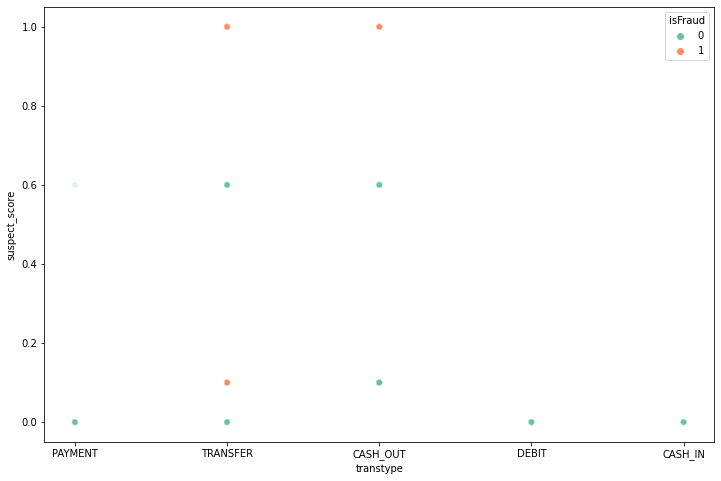

In [27]:
#generating the graph takes a long time will uncomment before publishing it
sns.scatterplot('transtype', 'suspect_score', data=paysim_data_df, hue='isFraud',
          palette='Set2', alpha=0.2)
plt.gcf().set_size_inches(12,8);

/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


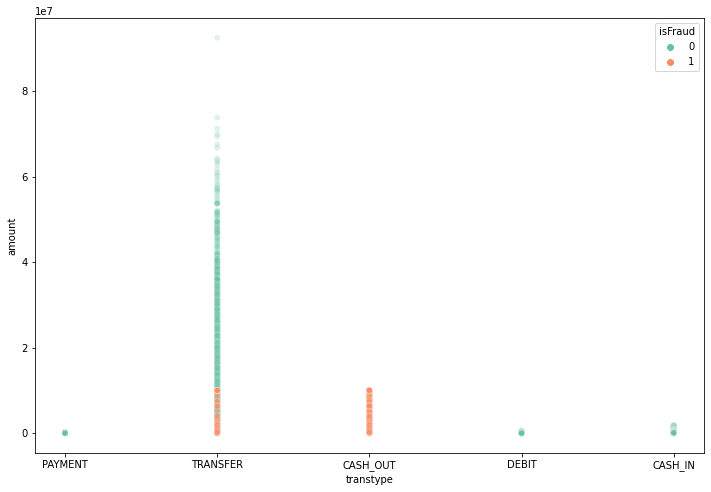

In [28]:
sns.scatterplot('transtype', 'amount', data=paysim_data_df, hue='isFraud',
           palette='Set2', alpha=0.2)
plt.gcf().set_size_inches(12,8);

The separation is not linear but it appears a non-linear model should be able to find a decision boundary

### One-hot Encoding `transtype`
`transtype` will be one-hot encoded.  

In [29]:
ohe = OneHotEncoder(sparse=False)

np_data_type = np.array(paysim_data_df["transtype"])
np_data_type = np_data_type.reshape(-1,1)
np_data_type_ohe = ohe.fit_transform(np_data_type)

np_data_type_ohe_df= pd.DataFrame(np_data_type_ohe,
                           columns=ohe.get_feature_names(['transtype']), #create meaningful column names
                           index=paysim_data_df.index) #keep the same index values

paysim_data_df = pd.concat([paysim_data_df, np_data_type_ohe_df], axis=1)
#paysim_data_df.head()

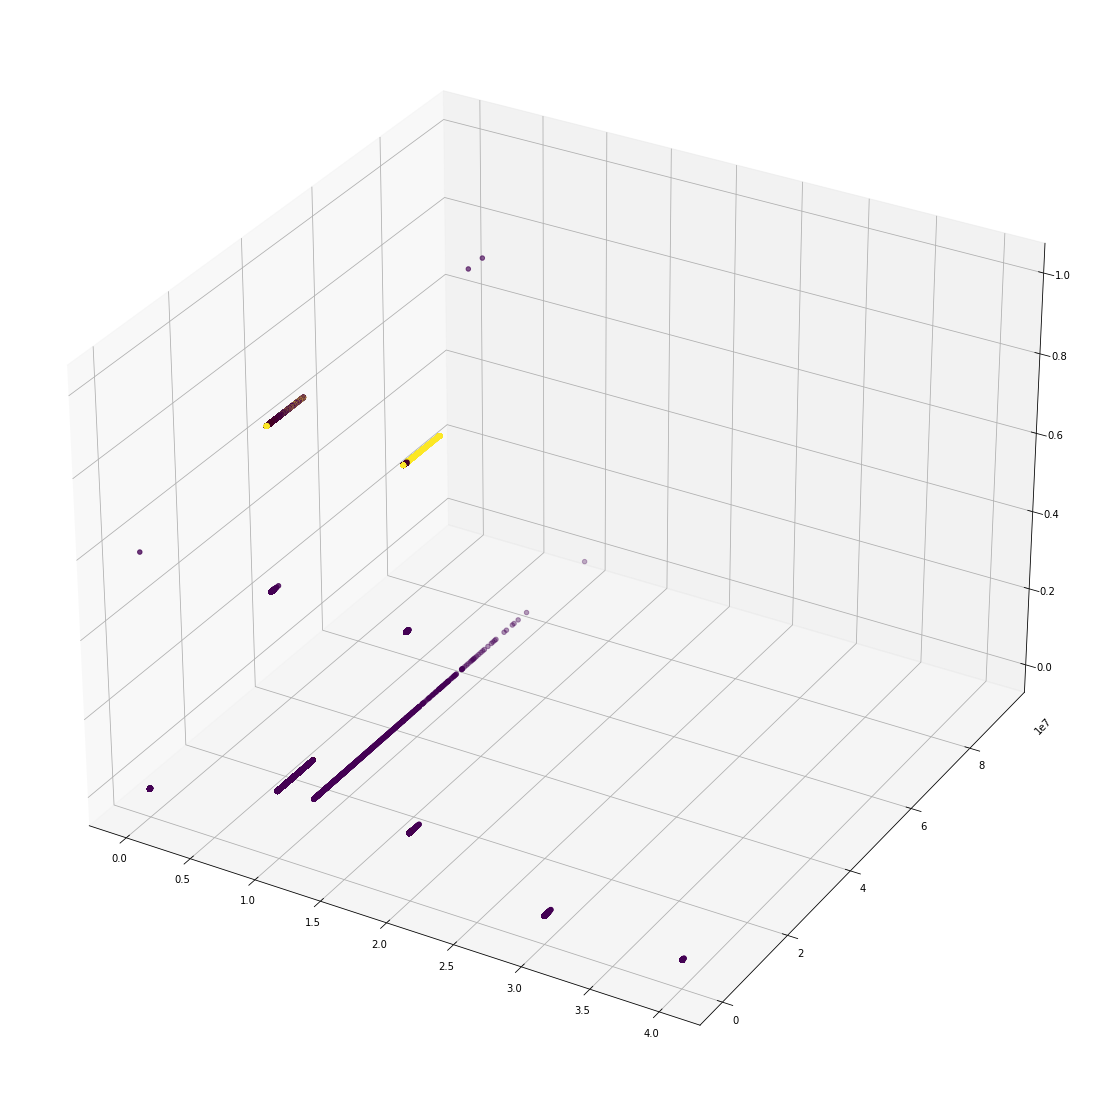

In [30]:
#What am I trying to show: That you can separate isfraud==1 and isfraud==0 using the xyz that I give below
w = "isFraud"
x = "transtype"
y = "amount"
z = "suspect_score"

#data frame that will get plotted Plot DF
plot_dict = {"X":paysim_data_df[x], "Y":paysim_data_df[y], "Z":paysim_data_df[z], "W":paysim_data_df[w]}

plot_df = pd.DataFrame(plot_dict)

plot_df["X"].replace("PAYMENT",0,inplace=True)
plot_df["X"].replace("TRANSFER",1,inplace=True)
plot_df["X"].replace("CASH_OUT",2,inplace=True)
plot_df["X"].replace("CASH_IN",3,inplace=True)
plot_df["X"].replace("DEBIT",4,inplace=True)

#write out to CSV for interactive ploting
PLOT_CSV_FILE = open("../Data/plot_df.csv","w")
plot_df.to_csv(PLOT_CSV_FILE)
PLOT_CSV_FILE.close()

fig = plt.figure(figsize=(20,20))

ax = fig.gca(projection="3d")
ax.scatter3D(plot_df["X"],plot_df["Y"],plot_df["Z"],c=plot_df["W"],depthshade=True)


Takeaways: `suspect_score` helps separate the data that belongs to the different classes but is not perfect.

# Model Selection

This function will be used to print confusion matrices

In [31]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=18):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names, )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

## Base Line Model

The baseline model chosen is **random** guessing where it will predict a transaction is fraudulent 50% of the time and non-fraudulent the other 50% of the time.

In [32]:
X = paysim_data_df[["step","amount","transtype_CASH_IN","transtype_CASH_OUT","transtype_DEBIT","transtype_PAYMENT","transtype_TRANSFER"]]
Y = paysim_data_df["isFraud"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

number_of_test_samples = X_test.shape[0]
y_pred_zero = np.zeros(number_of_test_samples // 2)
y_pred_one = np.ones( number_of_test_samples -  y_pred_zero.shape[0] )

y_pred = np.concatenate((y_pred_zero, y_pred_one),axis=0)
y_pred = y_pred.reshape(-1,)
y_pred = np.random.permutation(y_pred)



### Model Evaluation

In [33]:
target_names = ["NotFraud","Fraud"]

print(classification_report(Y_test, y_pred,target_names=target_names))

              precision    recall  f1-score   support

    NotFraud       1.00      0.50      0.67    635439
       Fraud       0.00      0.52      0.00       824

    accuracy                           0.50    636263
   macro avg       0.50      0.51      0.33    636263
weighted avg       1.00      0.50      0.67    636263



Thoughts about random guessing model:

Precision (TP/(TP+FP)) and recall (TP/(TP+FN)) are high for the `NotFraud` class because most (99.97%) of the response variables in the test set are `NotFraud`. Precision and recall are very low for `Fraud` because there are very few chances to guess right and the random guessing model does not perform well in identifying them.

Accuracy is meaningless for the same reason: It's easy to get 50% right as the vast majority of the results belong to one class. 

## Logistic Regression

Going to build a logistic model with all of the desired features.

In [34]:
X = paysim_data_df[["step","amount","oldbalanceOrg",
                      "newbalanceOrig",
                      "oldbalanceDest",
                      "newbalanceDest",
                      "suspect_score",
                      "transtype_CASH_IN",
                      "transtype_CASH_OUT",
                      "transtype_DEBIT",
                      "transtype_PAYMENT",
                      "transtype_TRANSFER"]]
Y = paysim_data_df["isFraud"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=TEST_SIZE, random_state=RANDOM_STATE)

normalizer = StandardScaler()
X_train_normal = normalizer.fit_transform(X_train.values)
X_test_normal = normalizer.transform(X_test.values)

In [35]:
#before running on the gpu I need to convert the pd df's to cudf df's
X_train_normal = pd.DataFrame(X_train_normal)
X_test_normal = pd.DataFrame(X_test_normal)
Y_train = pd.DataFrame(Y_train)
X_train_norm_cdf = cudf.from_pandas(X_train_normal)
X_test_norm_cdf = cudf.from_pandas(X_test_normal)
Y_train_cdf = cudf.from_pandas(Y_train)


In [36]:
logisticRModel = gpuLogisticRegression(C=100.0,max_iter=2000)

start_time = datetime.datetime.now()
logisticRModel.fit(X_train_norm_cdf,Y_train_cdf)
end_time = datetime.datetime.now()
print("training time is {}".format(end_time - start_time))

training time is 0:00:00.580866


### Model Evaluation

In [37]:
Y_pred = logisticRModel.predict(X_test_norm_cdf)
Y_pred = Y_pred.to_pandas()
Y_pred = np.array(Y_pred)
print(type(Y_pred),Y_pred.shape)
print(classification_report(Y_test, Y_pred,target_names=target_names))

<class 'numpy.ndarray'> (636263,)
              precision    recall  f1-score   support

    NotFraud       1.00      1.00      1.00    635439
       Fraud       0.92      0.15      0.25       824

    accuracy                           1.00    636263
   macro avg       0.96      0.57      0.63    636263
weighted avg       1.00      1.00      1.00    636263



The model's performance,though in some respects better than random guessing, has a poor recall for `isFraudulent==1` data samples. Given that the main goal is to develop a model that detects all fraudulent transactions in a vast sea of non-fraudulent transactions we will have to continue the  search for a model. Next will try oversampling the data set to see if the logistic model can improve

## Logistic Model with Over Sampling

In [38]:
oversampler = RandomOverSampler(random_state=RANDOM_STATE)
X_resampled, Y_resampled = oversampler.fit_sample(X,Y)


In [39]:
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled,test_size=TEST_SIZE, random_state=RANDOM_STATE)
X_train_normal = normalizer.fit_transform(X_train.values)
X_test_normal = normalizer.transform(X_test.values)


In [40]:
#before running on the gpu I need to convert the pd df's to cudf df's
X_train_normal = pd.DataFrame(X_train_normal)
X_test_normal = pd.DataFrame(X_test_normal)
Y_train = pd.DataFrame(Y_train)
X_train_norm_cdf = cudf.from_pandas(X_train_normal)
X_test_norm_cdf = cudf.from_pandas(X_test_normal)
Y_train_cdf = cudf.from_pandas(Y_train)

In [41]:
logisticRModelOverSampled = gpuLogisticRegression(C=100.0,max_iter=2000)

start_time = datetime.datetime.now()
logisticRModelOverSampled.fit(X_train_norm_cdf,Y_train_cdf)
end_time = datetime.datetime.now()
print("training time is {}".format(end_time - start_time))

training time is 0:00:00.324292


### Model Evaluation

To properly evaluate the model, I recreate the test data set based on the original data frame. Scoring the model based on the oversampled data frame is not a real measure of the model's performance

In [42]:
X = paysim_data_df[["step","amount","oldbalanceOrg",
                      "newbalanceOrig",
                      "oldbalanceDest",
                      "newbalanceDest",
                      "suspect_score",
                      "transtype_CASH_IN",
                      "transtype_CASH_OUT",
                      "transtype_DEBIT",
                      "transtype_PAYMENT",
                      "transtype_TRANSFER"]]
Y = paysim_data_df["isFraud"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=TEST_SIZE, random_state=RANDOM_STATE)

normalizer = StandardScaler()
X_train_normal = normalizer.fit_transform(X_train.values)
X_test_normal = normalizer.transform(X_test.values)



In [43]:
#before running on the gpu I need to convert the pd df's to cudf df's
X_train_normal = pd.DataFrame(X_train_normal)
X_test_normal = pd.DataFrame(X_test_normal)
Y_train = pd.DataFrame(Y_train)
X_train_norm_cdf = cudf.from_pandas(X_train_normal)
X_test_norm_cdf = cudf.from_pandas(X_test_normal)
Y_train_cdf = cudf.from_pandas(Y_train)


In [44]:
Y_pred = logisticRModelOverSampled.predict(X_test_norm_cdf)

In [45]:
Y_pred = Y_pred.to_pandas()
Y_pred = np.array(Y_pred)
print(type(Y_pred),Y_pred.shape)
print(classification_report(Y_test, Y_pred,target_names=target_names))

<class 'numpy.ndarray'> (636263,)
              precision    recall  f1-score   support

    NotFraud       1.00      0.54      0.70    635439
       Fraud       0.00      1.00      0.01       824

    accuracy                           0.54    636263
   macro avg       0.50      0.77      0.35    636263
weighted avg       1.00      0.54      0.70    636263



This model's performance is improved over the model that was trained on the normally sampled data set; however, the precision of the `Fraud` class is 0 (meaning that there are vastly more `NotFraud` transactions that have been labled as fraudulent than there are `Fraud` transactions that have been labeled as `Fraudulent`. This defeats the purpose of automating fraud detection.

Here are the value counts to illustrate this point:

In [46]:
Y_pred = pd.DataFrame(Y_pred)
Y_pred.value_counts()

0    344791
1    291472
dtype: int64

In [47]:
Y_test = pd.DataFrame(Y_test)
Y_test.value_counts()

isFraud
0          635439
1             824
dtype: int64

The model labeled 291472 transactions as fraudulent when there were only 824 truly fraudulent transactions in that set of data.

Although the feature `suspect_rating` provided linear separation it was not perfectly linear, and thus I'm thinking I'll need to use a model capable of converging to a non-linear decision boundary if I want to improve performance (especially recall of `isFraud==1`). Although there are several non linear models models (naive bayes classifier, SVM classifier,KNN) I need a model that can fit in a reasonable time, predict in a reasonable time, and have some resistance to over-fitting, in addition to being non-linear. I've decided to use ensemble models. I elaborate on them in the following sections.

## Random Forest Model

I will now use a [random forest model](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=randomforestclassifier#sklearn.ensemble.RandomForestClassifier). The reason I will do this is because the random forest model utilizes an algorithm called _bagging_. Bagging is an ensemble method where the data set will be split into several randomly generated data sets. Each data set will train a model. Then during forward passes of the model, the final prediction will be a function of the majority vote prediction, or some variation thereof.

The random forest model utilizes an ensemble of decision tree classifiers. The benfit of decision trees is that they can model very complex data sets without a lot of pre-processing of the data (normalization not required, removal of null rows note required); however the downside of decision trees is that they can overfit the training data leading to high variance in predictions.

The benefit of combining trees in a bagging ensemble is that what you get is a resultant model that enables complexity (via the trees) but that counter-acts variation by performing predictions as a function of a combination of several different trees trained on different parts of the data set.

In [48]:
X = paysim_data_df[["step","amount","oldbalanceOrg",
                      "newbalanceOrig",
                      "oldbalanceDest",
                      "newbalanceDest",
                      "suspect_score",
                      "transtype_CASH_IN",
                      "transtype_CASH_OUT",
                      "transtype_DEBIT",
                      "transtype_PAYMENT",
                      "transtype_TRANSFER"]]
Y = paysim_data_df["isFraud"]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=TEST_SIZE, random_state=RANDOM_STATE)
X_train_normal = normalizer.fit_transform(X_train.values)
X_test_normal = normalizer.transform(X_test.values)


In [49]:
X_train.columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'suspect_score', 'transtype_CASH_IN',
       'transtype_CASH_OUT', 'transtype_DEBIT', 'transtype_PAYMENT',
       'transtype_TRANSFER'],
      dtype='object')

In [50]:
#before running on the gpu I need to convert the pd df's to cudf df's
X_train_normal = pd.DataFrame(X_train_normal)
X_test_normal = pd.DataFrame(X_test_normal)
Y_train = pd.DataFrame(Y_train)
Y_test = pd.DataFrame(Y_test)
X_train_norm_cdf = cudf.from_pandas(X_train_normal)
X_test_norm_cdf = cudf.from_pandas(X_test_normal)
Y_train_cdf = cudf.from_pandas(Y_train)
Y_test_cdf = cudf.from_pandas(Y_test)

In [51]:
#The cuML framework doesn't support prediction on 64-bit floating point
#numbers for this model so converting the dataset to 32-bit floating point numbers
X_train32b_norm_cdf = X_train_norm_cdf.astype(cnp.float32)
Y_train32b_cdf = Y_train_cdf.astype(cnp.float32)

randforestModel = gpuRandomForestClassifier()

start_time = datetime.datetime.now()
randforestModel.fit(X_train32b_norm_cdf,Y_train32b_cdf)
end_time = datetime.datetime.now()
print("training time is {}".format(end_time - start_time))

training time is 0:00:01.427481


### Model Evaluation


In [52]:
Y_pred = randforestModel.predict(X_test_norm_cdf)
Y_pred = Y_pred.to_pandas()
Y_pred = np.array(Y_pred)
print(classification_report(Y_test, Y_pred,target_names=target_names))

              precision    recall  f1-score   support

    NotFraud       1.00      1.00      1.00    635439
       Fraud       1.00      0.89      0.94       824

    accuracy                           1.00    636263
   macro avg       1.00      0.95      0.97    636263
weighted avg       1.00      1.00      1.00    636263



In [53]:
Y_pred_prob = randforestModel.predict_proba(X_test_norm_cdf)
Y_pred_prob = Y_pred_prob.to_pandas()
Y_pred_prob = np.array(Y_pred_prob)
precision_curve, recall_curve, threshold_curve = precision_recall_curve(Y_test, Y_pred_prob[:,1] )


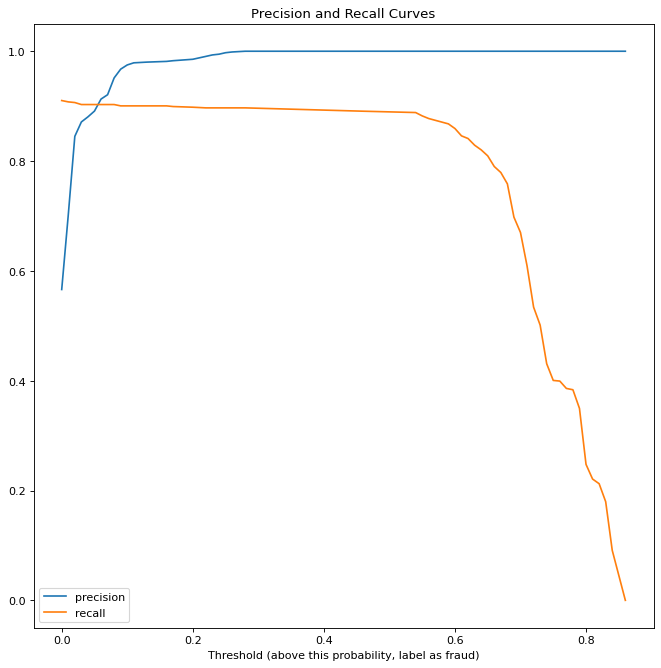

In [54]:
plt.figure(figsize=(10,10),dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

(636263, 1) (636263, 2)
ROC AUC score =  0.9550534215570287


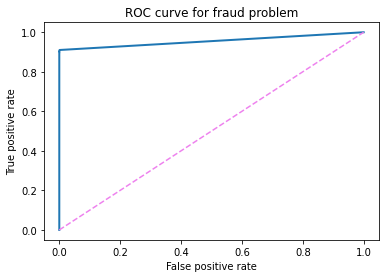

In [55]:
print(Y_test.shape,Y_pred_prob.shape)
FalsePosRate, TruePosRate, Thresh = roc_curve(Y_test, Y_pred_prob[:,1])
plt.plot(FalsePosRate, TruePosRate,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(Y_test, Y_pred_prob[:,1]))

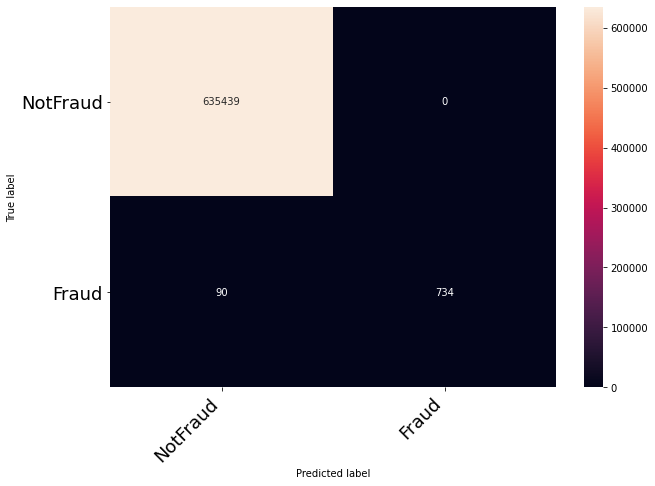

In [56]:
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=Y_pred)
cm = print_confusion_matrix(conf_matrix,target_names)

## XGBoost Model
Will now build a gradient boosted model, called [XGBoost](https://xgboost.readthedocs.io/en/latest/tutorials/model.html). In short gradient boosting is taking a set of classifiers, stacking them serially, and training `model i` in the stack against the dataset targeting the losses (differences between label and prediction) made by `model i-1` in the stack (where `model i` comes after `model i-1` in the stack). The final forward pass is a summation of all the serially connected models. See the link for more details.

This ensembles a set of decision trees as well and is another way to balance variance with the ability to create complex decision boundaries.


In [57]:
type(X_train_normal),X_train_normal.shape

(pandas.core.frame.DataFrame, (5726358, 12))

In [58]:
xgb_model = XGBClassifier()

start_time = datetime.datetime.now()
xgb_model.fit(X_train_normal,Y_train)
end_time = datetime.datetime.now()

print("training time is {}".format(end_time - start_time))



/home/magreen/anaconda3_2020_07/envs/metisgpulinux2venv/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[16:32:24] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1603299467566/work/src/gbm/gbtree.cc:147: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[16:32:27] WARNING: /opt/conda/envs/rapids/conda-bld/xgboost_1603299467566/work/src/learner.cc:1036: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
training time is 0:04:19.983222


In [59]:
X_test_normal.shape

(636263, 12)

### Model Evaluation


In [60]:
Y_pred = xgb_model.predict(X_test_normal)
print(classification_report(Y_test, Y_pred,target_names=target_names))

              precision    recall  f1-score   support

    NotFraud       1.00      1.00      1.00    635439
       Fraud       0.99      0.95      0.97       824

    accuracy                           1.00    636263
   macro avg       1.00      0.98      0.99    636263
weighted avg       1.00      1.00      1.00    636263



In [61]:
Y_pred_prob = xgb_model.predict_proba(X_test_normal)
precision_curve, recall_curve, threshold_curve = precision_recall_curve(Y_test, Y_pred_prob[:,1] )


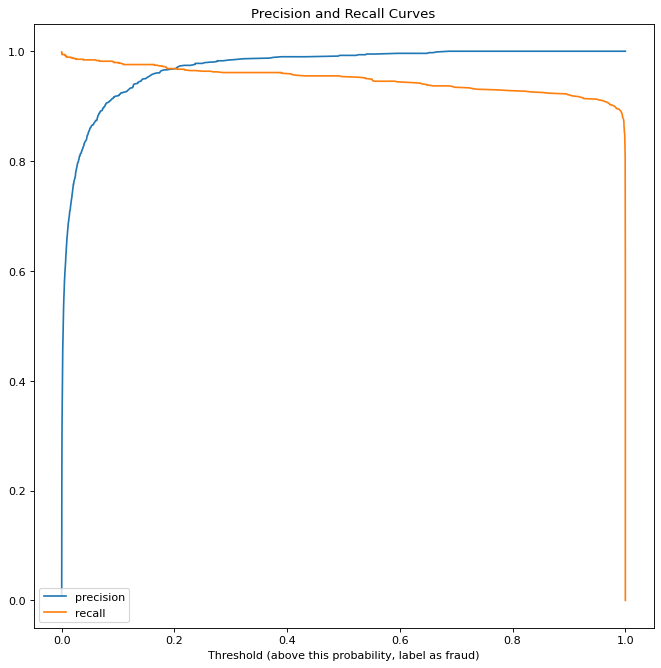

In [62]:
plt.figure(figsize=(10,10),dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

ROC AUC score =  0.9996941950551516


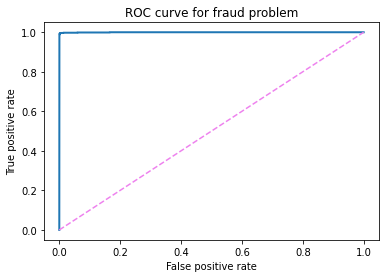

In [63]:
FalsePosRate, TruePosRate, Thresh = roc_curve(Y_test, Y_pred_prob[:,1])
plt.plot(FalsePosRate, TruePosRate,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for fraud problem');
print("ROC AUC score = ", roc_auc_score(Y_test, Y_pred_prob[:,1]))

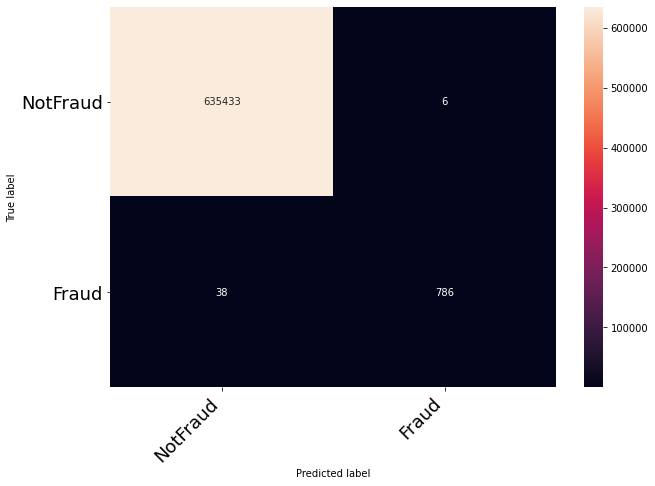

In [64]:
conf_matrix = confusion_matrix(y_true=Y_test, y_pred=Y_pred)
cm = print_confusion_matrix(conf_matrix,target_names)

Double checking XGBoost model by looking at feature importance.

Text(0.5, 1.0, 'orering of features by importance to the trained model')

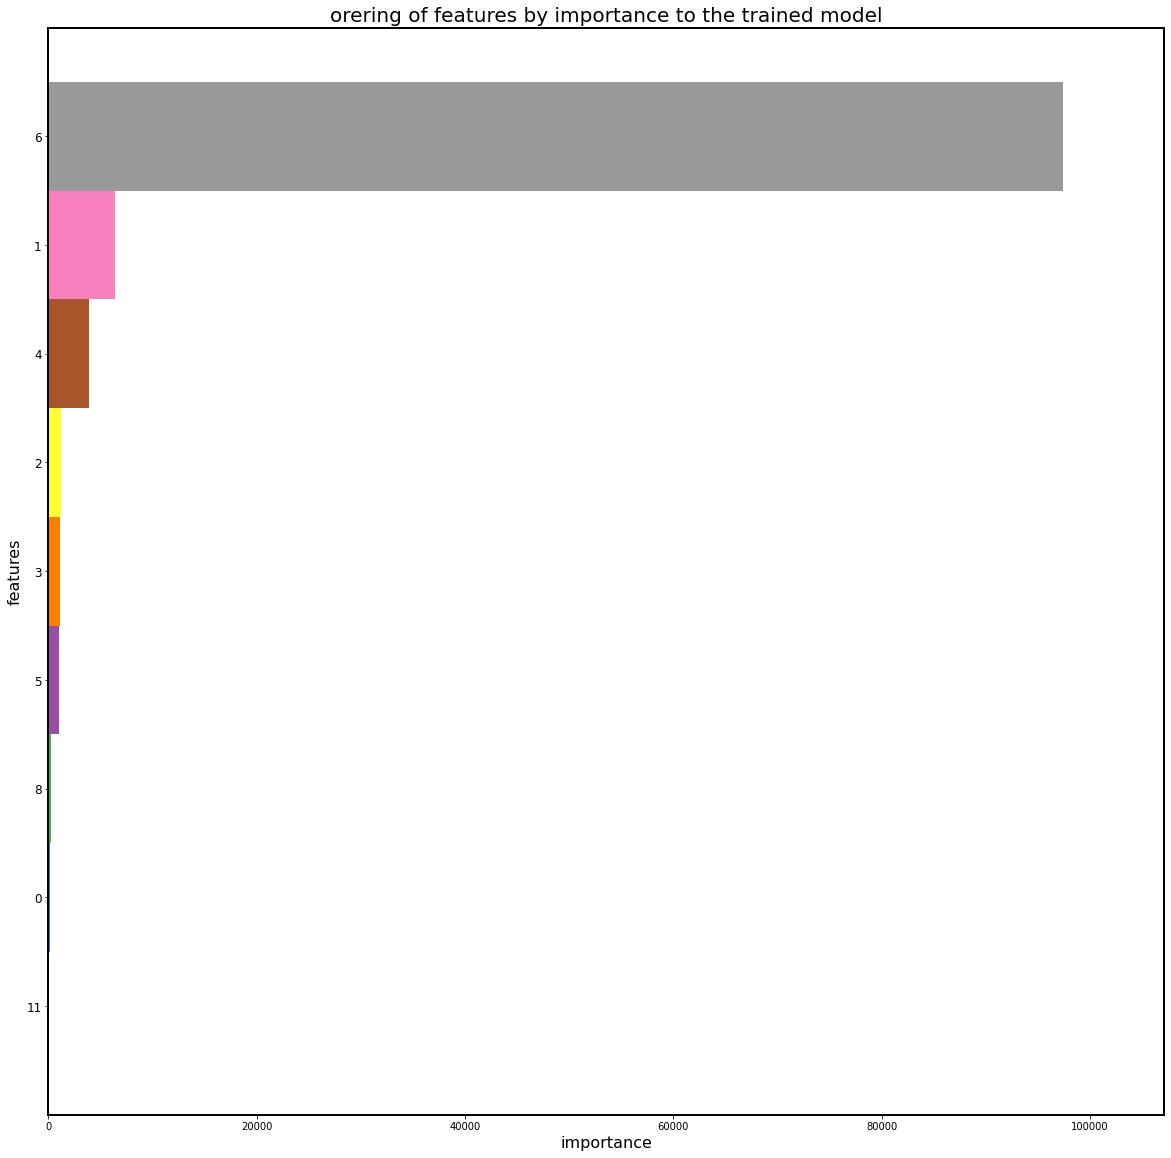

In [65]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)
colors = plt.cm.Set1(np.linspace(0,1,9))
ax = plot_importance(xgb_model,height=1,color=colors,grid=False,show_values=False, importance_type="cover",ax=ax);

for axis in ["top","bottom","left","right"]:
    ax.spines[axis].set_linewidth(2)
    
ax.set_xlabel("importance",size=16);
ax.set_ylabel("features",size=16);
ax.set_yticklabels(ax.get_yticklabels(),size=12);
ax.set_title("orering of features by importance to the trained model",size=20)


Given that the graphs in the EDA section of this notebook indicated that they provide linear separation of `isFraud==0` from `isFraud==1` (though in a new dimension) it's not suprising that feature no 6(`suspect_rating`) was of the most importance.

# Conclusion

Although the numbers indicate that the XGBoost model is better--its `AUC=0.999` vs the random forest's `AUC=0.955`--the confusion matrix reveals something that would have to be considered in light of possible business priorities.

The number of times that the XGBoost model mis-labels something that is not fraud is 6, whereas it's 0 in the random forest model. If the business cost to resolve cases that are falsely labeled as frauds is much greater than the cost to resolve cases that are falsely labeled as not fraud, then the random forest model will be more desirable model from a business standpoint even though it does not perform better statistically.

Although I would want to seek knowledgeable people in the mobile payments organization to confirm this, I speculate that the converse is true: It's more expensive and harder to catch and resolve cases of fraud that go undetected than to resolve cases that are falsely detected as fraud, especially with a model that falsely labels 6 non-fraudulent cases per 636,263 total cases.

Saving the model to be used by the web application

In [66]:
XGB_MODEL_PICKLE_FILE = open("../Data/xgb_model.pkl","wb")
pickle.dump(xgb_model,XGB_MODEL_PICKLE_FILE)

#saving normalizer as well
NORMALIZER_PICKLE_FILE = open("../Data/normalizer.pkl","wb")
pickle.dump(normalizer,NORMALIZER_PICKLE_FILE)

XGB_MODEL_PICKLE_FILE.close()
NORMALIZER_PICKLE_FILE.close()